In [1]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# print(tf.__version__)

In [2]:
def read_and_prepare_data():
    
    fashion_mnist = tf.keras.datasets.fashion_mnist

    (x_train, _), (x_test, _) = fashion_mnist.load_data()
    # Normalize train and test data
    x_train = x_train.astype('float64') / 255.
    x_test = x_test.astype('float64') / 255.

    # Reshape so that each instance is a linear array of 784 normalized pixel values
    x_train = x_train.reshape((len(x_train), 784))
    x_test = x_test.reshape((len(x_test), 784))
    print (x_train.shape, x_test.shape)

    # Add random noise to the image
    noise_factor = 0.2
    x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
    x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

    # Clip the resulting values so that they don't fall outside the upper and lower normalized value of 0 and 1
    x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
    x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)


    n = 10  # Number of images to display 

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_noisy[i].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    return (tf.convert_to_tensor(x_train, dtype=tf.float64), tf.convert_to_tensor(x_test, dtype=tf.float64), x_train_noisy, x_test_noisy)

def nn_architecture(no_of_features):
    # Creating the variables as per the given architecture
    no_of_neurons_hidden_layer1 = 128
    no_of_neurons_hidden_layer2 = 64
    no_of_neurons_hidden_layer3 = 32
    no_of_neurons_hidden_layer4 = 64
    no_of_neurons_hidden_layer5 = 128
    no_of_output_units = 784

    # Declaring weights and bias for the NN
    W1 = tf.Variable(tf.random.normal(shape=(no_of_neurons_hidden_layer1, no_of_features), seed=0, dtype=tf.float64) * 0.1)
    b1 = tf.Variable([0], dtype=tf.float64)

    W2 = tf.Variable(tf.random.normal(shape=(no_of_neurons_hidden_layer2, no_of_neurons_hidden_layer1), seed=0, dtype=tf.float64) * 0.1)
    b2 = tf.Variable([0], dtype=tf.float64)

    W3 = tf.Variable(tf.random.normal(shape=(no_of_neurons_hidden_layer3, no_of_neurons_hidden_layer2), seed=0, dtype=tf.float64) * 0.1)
    b3 = tf.Variable([0], dtype=tf.float64) 

    W4 = tf.Variable(tf.random.normal(shape=(no_of_neurons_hidden_layer4, no_of_neurons_hidden_layer3), seed=0, dtype=tf.float64) * 0.1)
    b4 = tf.Variable([0], dtype=tf.float64)

    W5 = tf.Variable(tf.random.normal(shape=(no_of_neurons_hidden_layer5, no_of_neurons_hidden_layer4), seed=0, dtype=tf.float64) * 0.1)
    b5 = tf.Variable([0], dtype=tf.float64)

    W6 = tf.Variable(tf.random.normal(shape=(no_of_output_units, no_of_neurons_hidden_layer5), seed=0, dtype=tf.float64) * 0.1)
    b6 = tf.Variable([0], dtype=tf.float64)

    # Construct the dictionary with initialized weights and bias values
    weights_bias_dict = {'W1': W1, 'W2': W2, 'W3': W3, 'W4': W4, 'W5': W5, 'W6': W6,
                         'b1': b1, 'b2': b2, 'b3': b3, 'b4': b4, 'b5': b5, 'b6': b6}
    return weights_bias_dict

# Sigmoid function 1/(1+exp(-x))
def sigmoid(hypothesis_output_layer):
    predictions = tf.cast(1 / (1 + tf.exp(-hypothesis_output_layer)), tf.float64)
    return predictions

# Function to calculate mean absolute error
def mean_absolute_error(predictions, actual):
    actual = tf.transpose(actual)  # Same shape for both predicted and actual data set
    
    # Absolute difference/error
    abs_error = tf.cast(tf.abs(tf.math.subtract(predictions, actual)), tf.float64)
    
    # summing up for entire dataset and taking the mean value
    mean_abs_error = tf.cast(tf.reduce_mean(tf.reduce_sum(abs_error, axis = 0)), tf.float64)
    
    return mean_abs_error

# Function to push the data through the network
def forward_pass(data, weights_bias_dict):
    no_of_layers = 6
    data = tf.transpose(data)
    activations = data

    # pushing the feature dataset through 5 layers
    for l in range(1, no_of_layers):
        hypothesis = tf.cast(tf.matmul(weights_bias_dict['W' + str(l)], activations) + weights_bias_dict['b' + str(l)], tf.float64)
        activations = tf.cast(tf.nn.relu(hypothesis), tf.float64)
    
    # for last layer (6th layer)
    hypothesis = tf.cast(tf.matmul(weights_bias_dict['W' + str(l + 1)], activations) + weights_bias_dict['b' + str(l + 1)], tf.float64)
    predictions = tf.cast(sigmoid(hypothesis), tf.float64)

    return predictions

# Function to iterate for max_iterations and upate the weights and bias after calculating the gradient
def train_autoencoder(x_train, x_train_noisy, x_test, x_test_noisy, weights_bias_dict):

    max_iterations = 2500
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    tr_loss = []
    te_loss = []

    for i in range(max_iterations):
        # Record the computation
        with tf.GradientTape() as tape:
            predictions = forward_pass(x_train_noisy, weights_bias_dict)
            train_loss = mean_absolute_error(predictions, x_train)

        # Calculate the gradients
        gradients = tape.gradient(train_loss, list(weights_bias_dict.values()))

        test_predictions = forward_pass(x_test_noisy, weights_bias_dict)
        test_loss = mean_absolute_error(test_predictions, x_test)
       
        tr_loss.append(train_loss)
        te_loss.append(test_loss)

        # update the weights and bias values as per calculated gradients
        adam_optimizer.apply_gradients(zip(gradients, list(weights_bias_dict.values())))
        
        print("Iteraions {}: MAE_train: {} MAE_test: {}".format(i, train_loss, test_loss))
    
    # Return the updated weights and bias values to test the model perfomance on noisy test data
    return (weights_bias_dict, tr_loss, te_loss)

def plot_curves(tr_loss, te_loss):
    plt.plot(np.arange(2500), tr_loss)
    plt.plot(np.arange(2500), te_loss)
    plt.title("loss")
    plt.xlabel('epoch')
    plt.ylabel("loss")
    plt.legend(['train', 'val'], loc='upper left')

def predict_and_display(x_test_noisy, x_test, weights_bias_dict):
    test_predictions = forward_pass(x_test_noisy, weights_bias_dict)
    test_predictions = tf.transpose(test_predictions)

    n = 10
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_predictions[i].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        # plt.imshow(x_test[i].reshape(28, 28))
        plt.imshow(tf.reshape(x_test[i], (28, 28)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


4423680/4422102 [==============================] - 0s 0us/step
(60000, 784) (10000, 784)


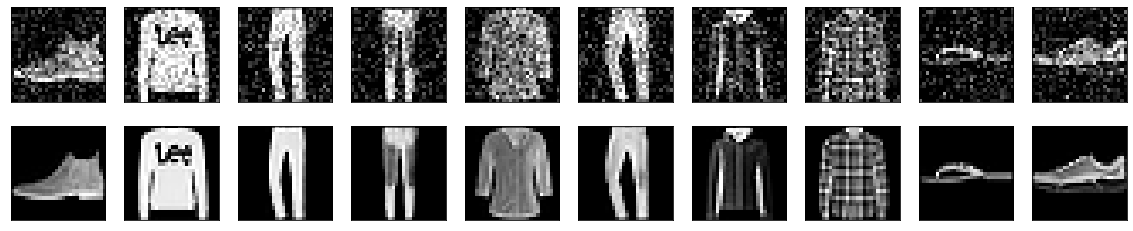

In [3]:
x_train, x_test, x_train_noisy, x_test_noisy = read_and_prepare_data()

In [4]:
# Converting the numpy arrays to tensors
x_train = tf.convert_to_tensor(x_train, dtype = tf.float64)
x_test = tf.convert_to_tensor(x_test, dtype = tf.float64)
x_train_noisy = tf.cast(x_train_noisy, dtype = tf.float64)
x_test_noisy = tf.cast(x_test_noisy, dtype = tf.float64)

In [5]:
# Get a dictionary with weights and bias initialized with random values
weights_bias_dict = nn_architecture(x_train.shape[1])

In [6]:
# Train the autoencode to the task of denoising the noisy images
trained_weight_bias_dict, tr_loss, te_loss = train_autoencoder(x_train, x_train_noisy, x_test, x_test_noisy, weights_bias_dict)

Iteraions 0: MAE_train: 300.0393680724112 MAE_test: 298.97631328879913
Iteraions 1: MAE_train: 277.0962157969931 MAE_test: 276.19206208385805
Iteraions 2: MAE_train: 232.09668400975684 MAE_test: 232.02825431398978
Iteraions 3: MAE_train: 205.61522140815438 MAE_test: 205.99100241849303
Iteraions 4: MAE_train: 190.164002336737 MAE_test: 190.50698213711954
Iteraions 5: MAE_train: 183.87713983454222 MAE_test: 184.1694738118059
Iteraions 6: MAE_train: 176.3143027809001 MAE_test: 176.52172607014316
Iteraions 7: MAE_train: 169.7696113313443 MAE_test: 169.88743206107807
Iteraions 8: MAE_train: 166.20596377948627 MAE_test: 166.23797109557444
Iteraions 9: MAE_train: 162.7697460156242 MAE_test: 162.85295554321453
Iteraions 10: MAE_train: 158.97942599589692 MAE_test: 159.13254589016043
Iteraions 11: MAE_train: 155.9353481369696 MAE_test: 156.15084985235998
Iteraions 12: MAE_train: 151.67544681023153 MAE_test: 151.8668565725574
Iteraions 13: MAE_train: 147.56829409320486 MAE_test: 147.6658889135453

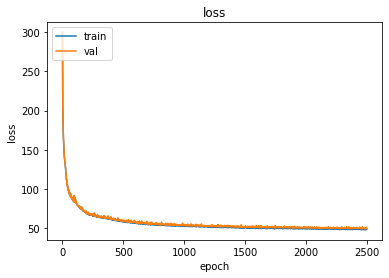

In [7]:
# 2500 iterations

plt.plot(np.arange(2500), tr_loss)
plt.plot(np.arange(2500), te_loss)
plt.title("loss")
plt.xlabel('epoch')
plt.ylabel("loss")
plt.legend(['train', 'val'], loc='upper left')

In [8]:
test_predictions = forward_pass(x_test_noisy, weights_bias_dict)

In [9]:
test_predictions.shape

TensorShape([784, 10000])

In [10]:
test_predictions = tf.transpose(test_predictions)

In [11]:
test_predictions.shape

TensorShape([10000, 784])

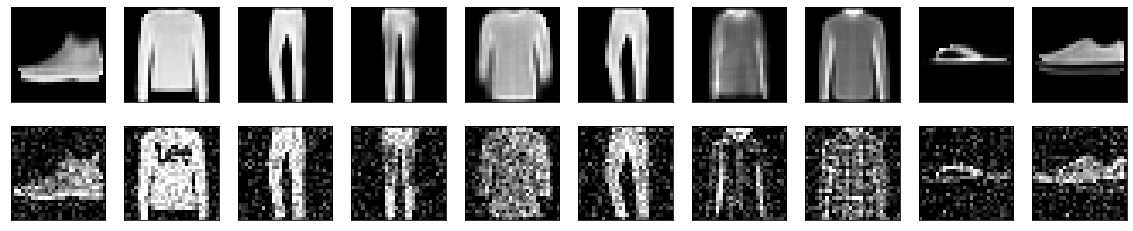

In [12]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_predictions[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    # plt.imshow(x_test[i].reshape(28, 28))
    plt.imshow(tf.reshape(x_test_noisy[i], (28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()